Notebook for training on relative wind angle features  

- Need to handle different time frequency data. Ex, fit data with 3 second freqeuency will be 15 second total interval.

Input features:
Concatenation of 5 time-series datapoints, each having:
- Speed of rider (m/s)
- Elevation delta from previous point (meters)
- Wind speed (m/s)
- Wind direction wrt rider direction (degrees)

Output labels: - 5 second power in watts (target)

In [1]:
import time
import datetime
import os
import sys
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from wind2watts.data.datasets import WindAnglePowerDataset
from wind2watts.fit.util import fit_to_df

%load_ext autoreload
%autoreload 2

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#### Load Data

In [3]:
activities = []
data_dir = '../../data/dataframes/strava_export/'
for file in os.listdir(data_dir):
    if not file.endswith('.csv'):
        continue
    df = pd.read_csv(os.path.join(data_dir, file))
    df['name'] = file.split('.')[0]
    activities.append(df)

#### Construct Datasets

In [4]:
from sklearn.model_selection import train_test_split
train_activities, test_activities = train_test_split(activities, test_size=0.2, random_state=42)

In [5]:
window_size = 5
batch_size = 32

In [7]:
from torch.utils.data import DataLoader

train_dataset = WindAnglePowerDataset(
    train_activities,
    window_size=window_size,
    device=device,
)

val_dataset = WindAnglePowerDataset(
    test_activities,
    window_size=window_size,
    window_scaler=train_dataset.window_scaler,
    power_scaler=train_dataset.power_scaler,
    device=device,
)

test_dataloaders = [DataLoader(WindAnglePowerDataset(
    [activity],
    window_size=window_size,
    window_scaler=train_dataset.window_scaler,
    power_scaler=train_dataset.power_scaler,
    device=device,
), shuffle = False) for activity in test_activities]

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=False)

len(train_dataloader)

11740

#### Define Model

In [11]:
import torch.nn as nn
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
       super(SimpleRNN, self).__init__() 
       self.rnn = nn.RNN(input_size = input_size, hidden_size = hidden_size, batch_first = True)
       self.fc1 = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        output, _ = self.rnn(x)
        output = self.fc1(output[:, -1, :])
        return output

In [42]:
learning_rate = 1e-3 
epochs = 50 

In [41]:
model = SimpleRNN(input_size = 6, hidden_size = 32)
model.train()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

model.to(device)
criterion.to(device)

MSELoss()

In [43]:
model_dir = '../../training_checkpoints/lat_lon/simplernn_v1p1/'
os.makedirs(model_dir, exist_ok=True)
min_loss = float('inf')

#### Training Loop

In [44]:
train_losses = []
val_losses = []
time_loading = 0
time_inferring = 0
for epoch in range(epochs):
    batch_loss = 0
    now = time.time()
    for i, (x, y) in enumerate(train_dataloader):
        time_loading += time.time() - now
        optimizer.zero_grad()
        now = time.time()
        output = model(x)
        time_inferring += time.time() - now
        loss = criterion(output, y)
        batch_loss += loss.item()
        loss.backward()
        optimizer.step()
        now = time.time()
    train_loss = batch_loss / len(train_dataloader)
    train_losses.append(train_loss)
    
    with torch.no_grad():
        val_loss = 0
        for i, (x, y) in enumerate(val_dataloader):
            output = model(x)
            loss = criterion(output, y)
            val_loss += loss.item()
        val_loss /= len(val_dataloader)
        val_losses.append(val_loss)
    
    if val_loss < min_loss:
        min_loss = val_loss
        torch.save(model.state_dict(), os.path.join(model_dir, 'best_model.pt'))

    print(f'Epoch: {epoch}, Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}')

Epoch: 0, Loss: 0.0111690206322367, Val Loss: 0.009489703472462242
Epoch: 1, Loss: 0.010760795389170841, Val Loss: 0.009521928566499372
Epoch: 2, Loss: 0.010517790755705029, Val Loss: 0.00908701497720796
Epoch: 3, Loss: 0.010448067426989184, Val Loss: 0.008672002349501579
Epoch: 4, Loss: 0.010339557231697676, Val Loss: 0.00849264950288839
Epoch: 5, Loss: 0.010223291600210273, Val Loss: 0.009241725150032262
Epoch: 6, Loss: 0.010152963017224124, Val Loss: 0.008560803002048353
Epoch: 7, Loss: 0.009641245257493193, Val Loss: 0.008339402545998045
Epoch: 8, Loss: 0.009451547052799266, Val Loss: 0.007657805903969954
Epoch: 9, Loss: 0.009320734552690176, Val Loss: 0.00772527318223621
Epoch: 10, Loss: 0.008931444458926723, Val Loss: 0.007684811638211142
Epoch: 11, Loss: 0.008439741720096159, Val Loss: 0.007845837923836101
Epoch: 12, Loss: 0.008317010004922633, Val Loss: 0.0076668830312512535
Epoch: 13, Loss: 0.008117813985733725, Val Loss: 0.007278226810955891
Epoch: 14, Loss: 0.007932529276714

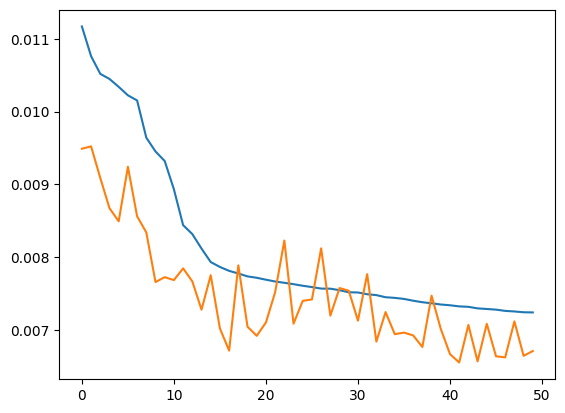

In [45]:
plt.plot(train_losses)
plt.plot(val_losses)

#### Model Eval

In [37]:
best_model = SimpleRNN(6, 32)
best_model.load_state_dict(torch.load('../training_checkpoints/lat_lon/simplernn_v1p0/best_model.pt'))

<All keys matched successfully>

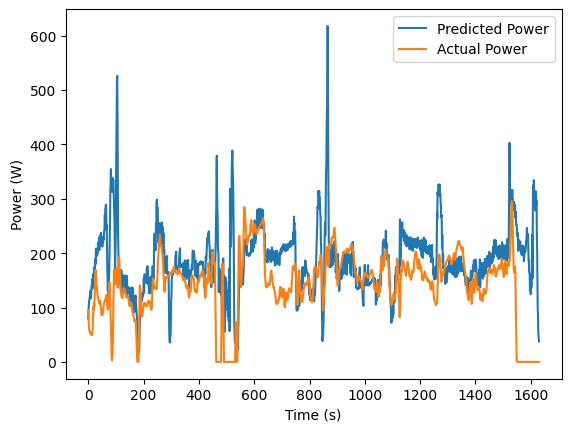

In [49]:
test_activity_dataloader = test_dataloaders[1]

powers = []
pred_powers =  []
for (window, power) in test_activity_dataloader:
    with torch.no_grad():
        power_pred = model(window)
    power_pred = train_dataset.power_scaler.inverse_transform(power_pred.cpu().numpy())
    power = train_dataset.power_scaler.inverse_transform(power.cpu().numpy())
    pred_powers.append(power_pred)
    powers.append(power)

powers = np.array(powers).reshape(-1)
pred_powers = np.array(pred_powers).reshape(-1)


plt.plot(pred_powers, label='Predicted Power')
plt.plot(powers, label='Actual Power')
plt.xlabel('Time (s)')
plt.ylabel('Power (W)')
plt.legend()

In [48]:
print(np.mean(powers))
print(np.mean(pred_powers))

141.52545
186.62175
